# Scenario Generation in EQ-Master

## Setup

In [1]:
import os
import json
import requests
import datetime
from bs4 import BeautifulSoup
from openai import AzureOpenAI
from langchain_openai import AzureChatOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [2]:
from chat_llms import *
from utils import *

import importlib
import prompts
importlib.reload(prompts)
from prompts import *

In [3]:
llm = creat_llm()
run_id_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

## Scenario Library Creation

In [4]:
def refine_slc_prompt(original_prompt, input_dict={}, num_comparison_choices=3):
    # get original output
    slc_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', original_prompt),
            ('human', scenario_library_creation_task_prompt),
        ]
    )
    slc_model = slc_prompt | llm
    scenario_library_output = slc_model.invoke(input_dict)
    scenario_library = scenario_library_output.content
    # critic -> comments
    slc_critic_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', slc_critic_system_prompt),
            ('human', slc_critic_task_prompt),
        ]
    )
    slc_critic = slc_critic_prompt | llm
    slc_critic_output = slc_critic.invoke({'scenario_library': scenario_library})
    slc_comments = slc_critic_output.content
    # refiner -> refined prompt
    slc_refiner_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', slc_refiner_system_prompt),
            ('human', slc_refiner_task_prompt),
        ]
    )
    slc_refiner = slc_refiner_prompt | llm
    refined_prompt_output = slc_refiner.invoke({'original_prompt': original_prompt, 'scenario_library': scenario_library, 'critic_comments': slc_comments})
    refined_prompt = refined_prompt_output.content
    # get refined output
    slc_refined_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', refined_prompt),
            ('human', scenario_library_creation_task_prompt),
        ]
    )
    slc_refined_model = slc_refined_prompt | llm
    refined_scenario_library_output = slc_refined_model.invoke(input_dict)
    refined_scenario_library = refined_scenario_library_output.content
    refined_slc_critic_output = slc_critic.invoke({'scenario_library': refined_scenario_library})
    refined_slc_comments = refined_slc_critic_output.content
    # pairwise comparison
    slc_comparison_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', slc_comparison_system_prompt),
            ('human', slc_comparison_task_prompt),
        ]
    )
    slc_comparison_model = slc_comparison_prompt | llm
    input_dict_for_comparison = {
        'slc_critic_system_prompt': slc_critic_system_prompt,
        'scenario_library_a': scenario_library,
        'scenario_library_b': refined_scenario_library,
    }
    comparison_better_list = []
    comparison_degree_list = []
    comparison_analysis_list = []
    for i in range(num_comparison_choices):
        comparison_analysis = slc_comparison_model.invoke(input_dict_for_comparison)
        comparison_analysis = comparison_analysis.content
        comparison_analysis_list.append(comparison_analysis)
        try:
            comparison_analysis_dict = json.loads(comparison_analysis)
        except:
            print(comparison_analysis)
        comparison_better_list.append(comparison_analysis_dict['better'])
        comparison_degree_list.append(comparison_analysis_dict['degree'])
    overall_better = max(set(comparison_better_list), key=comparison_better_list.count)
    average_degree = sum(comparison_degree_list) / len(comparison_degree_list)
    return {
        'original_prompt': original_prompt,
        'refined_prompt': refined_prompt,
        'overall_better': overall_better,
        'average_degree': average_degree,
        'scenario_library': safe_json_loads(scenario_library),
        'refined_scenario_library': safe_json_loads(refined_scenario_library),
        'critic_comments': safe_json_loads(slc_comments),
        'refined_critic_comments': safe_json_loads(refined_slc_comments),
        'comparison_analysis_list': [safe_json_loads(comparison_analysis) for comparison_analysis in comparison_analysis_list],
    }

### Refine Prompt

In [5]:
user_info = 'Programmer, Junior'
num_scenarios = 20

In [7]:
input_dict = {'user_info': user_info, 'num_scenarios': num_scenarios}
original_prompt = scenario_library_creation_original_system_prompt

max_refinement_rounds = 10
refinement_results_list = []
average_degree_list = []
overall_better_list = []
# runtime_str = datetime.datetime.now().strftime('%Y%m%d%-H%M%S')
for round_id in range(max_refinement_rounds):
    refinement_results = refine_slc_prompt(original_prompt, input_dict)
    refinement_results_list.append(refinement_results)

    refinement_results_file_path = f'results/slc_refinement_results_{round_id}_{run_id_str}.json'
    save_json(refinement_results_file_path, refinement_results)

    overall_better_list.append(refinement_results['overall_better'])
    average_degree_list.append(refinement_results['average_degree'])

    print(f'Round {round_id}: Prompt {refinement_results["overall_better"]} is better ({refinement_results["average_degree"]})')
    if refinement_results['overall_better'] == 1:
        original_prompt = refinement_results['refined_prompt']

    if round_id >= 3:
        latest_dedup_overall_better_list = list(set(overall_better_list[-3:]))
        if len(latest_dedup_overall_better_list) == 1 and latest_dedup_overall_better_list[0] == 0:
            break
        latest_dedup_average_degree_list = list(set(average_degree_list[-3:]))
        if len(latest_dedup_average_degree_list) == 1 and latest_dedup_average_degree_list[0] <= 0:
            break

Round 0: Prompt 1 is better (1.0)
Round 1: Prompt 0 is better (0.6666666666666666)
Round 2: Prompt 0 is better (0.5)
Round 3: Prompt 0 is better (0.5)


### Process Visualization

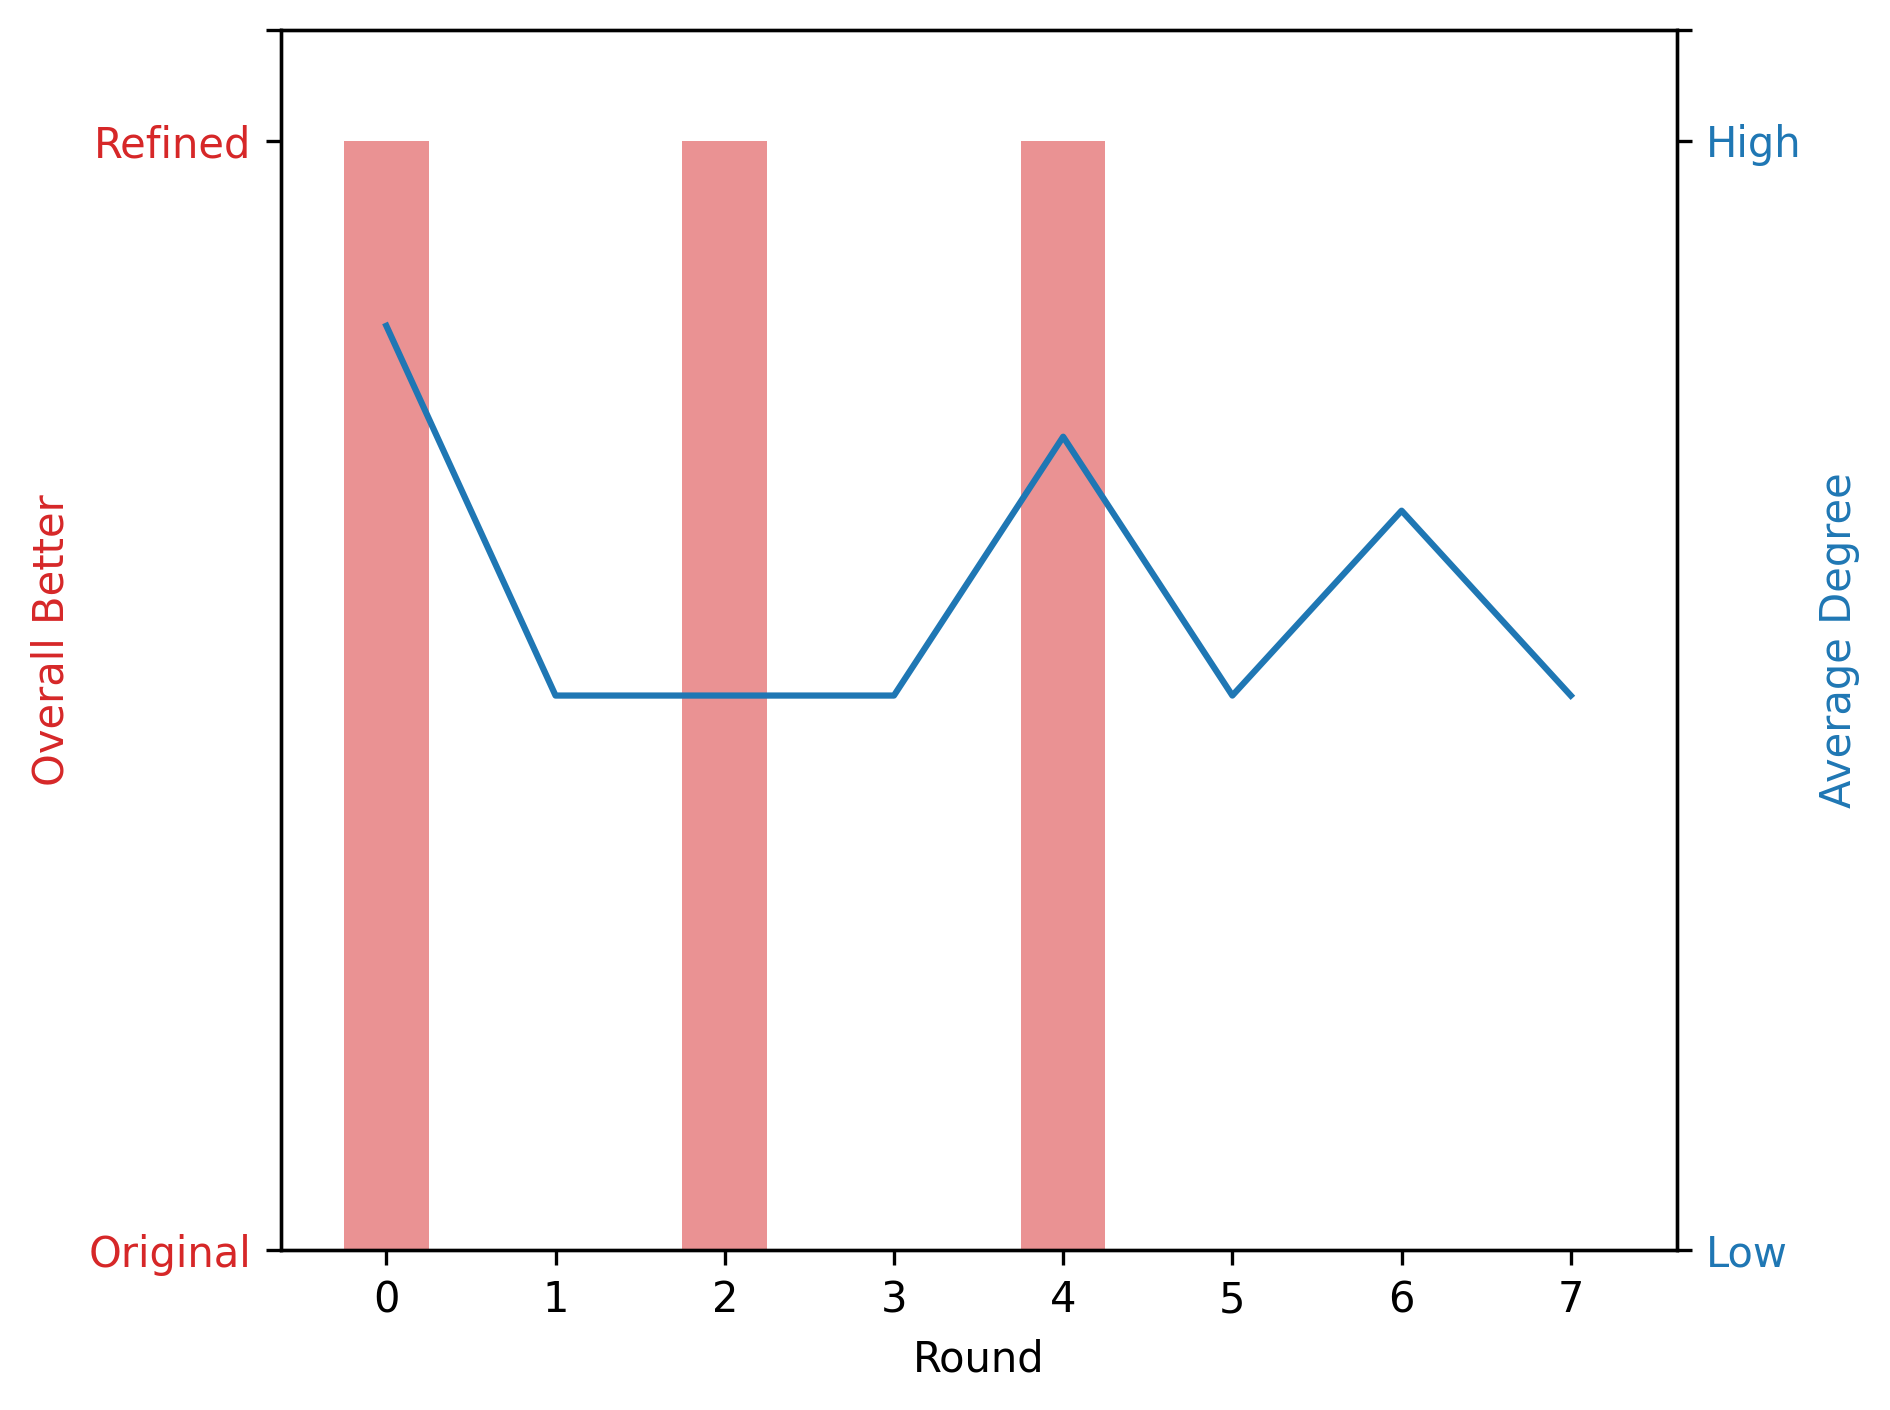

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(dpi=300)

round_list = list(range(len(overall_better_list)))

color = 'tab:red'
ax1.set_xlabel('Round')
ax1.set_ylabel('Overall Better', color=color)
ax1.bar(round_list, color=color, height=overall_better_list, alpha=0.5, width=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1.0, 1.1])
ax1.set_yticklabels(['Original', 'Refined', ''])


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Degree', color=color)
ax2.plot(round_list, average_degree_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1.0, 1.1])
ax2.set_yticklabels(['Low', 'High', ''])

fig.tight_layout()
plt.show()

### Final Output

In [58]:
original_slc_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', scenario_library_creation_original_system_prompt),
        ('human', scenario_library_creation_task_prompt),
    ]
)
original_slc_model = original_slc_prompt | llm
original_scenario_library_output = original_slc_model.invoke(input_dict)
original_scenario_library = original_scenario_library_output.content
save_json(f'results/original_scenario_library_{run_id_str}.json', json.loads(original_scenario_library))

In [61]:
final_scenario_library_creation_system_prompt = original_prompt
slc_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', final_scenario_library_creation_system_prompt),
        ('human', scenario_library_creation_task_prompt),
    ]
)
slc_model = slc_prompt | llm
scenario_library_output = slc_model.invoke(input_dict)
scenario_library = scenario_library_output.content
save_json(f'results/scenario_library_{run_id_str}.json', json.loads(scenario_library))

In [62]:
slc_comparison_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', slc_comparison_system_prompt),
        ('human', slc_comparison_task_prompt),
    ]
)
slc_comparison_model = slc_comparison_prompt | llm
input_dict_for_comparison = {
    'slc_critic_system_prompt': slc_critic_system_prompt,
    'scenario_library_a': original_scenario_library,
    'scenario_library_b': scenario_library,
}
comparison_analysis = slc_comparison_model.invoke(input_dict_for_comparison)
comparison_analysis = comparison_analysis.content
try:
    comparison_analysis_dict = json.loads(comparison_analysis)
except:
    print(comparison_analysis)

comparison_analysis_dict

{'better': 1,
 'degree': 0.5,
 'overall': '场景库B在情感维度的针对性、情感复杂度、和启发性方面表现更好，而场景库A在场景背景的多样性和真实性方面具有优势。',
 'comments': {'dimension_targeting': '场景库B明确标注了每个场景的情感维度，使得每个场景都能明确聚焦某个情商维度。而场景库A缺乏这一标注，对情商维度的针对性不够明确。',
  'scenario_diversity': '场景库A涵盖了较为丰富的职场情境和人际关系类型，而场景库B的情境虽然也多样，但主要集中在同事、上级和客户关系上。',
  'realism_perceptibility': '场景库A的场景背景更贴近实际职场生活，能够引发用户的情感共鸣。而场景库B虽然情境设计合理，但部分场景可能稍显刻意，不如A真实。',
  'emotional_complexity': '场景库B在每个场景中都明确标注了情感复杂度，并且涵盖了从低到高不同层次的情感挑战。而场景库A的情感复杂度不够明确。',
  'user_customization': '两者在用户定制性方面表现相似，都没有明确针对用户个性化信息进行场景定制。',
  'inspirational': '场景库B通过情感维度和情感复杂度的标注，能够更好地促使用户思考自己的情感反应与管理方式。而场景库A在启发性方面表现稍弱。',
  'output_format': '两个场景库的输出格式都符合规范，包含了必要的字段。'}}

## Situational Detail Generation

In [ ]:
scenario_library_dict = load_json(f'results/scenario_library_{run_id_str}.json')

In [19]:
user_info = 'Programmer, Junior'
scenario_info = {
    "id": "2",
    "title": "项目截止日期临近",
    "background": "项目的截止日期临近，你感觉自己有些跟不上进度。你的团队领导在每日站会上询问每个人的进展。",
    "user_role": "Junior Programmer",
    "relation_type": "上级关系",
    "emotional_dimension": "情绪掌控力"
}
num_situations = 5
sdg_input_dict = {'user_info': user_info, 'scenario_info': scenario_info, 'num_situations': num_situations}

### Refine Prompt

In [38]:
def refine_sdg_prompt(original_prompt, input_dict={}, num_comparison_choices=3):
    # get original output
    sdg_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', original_prompt),
            ('human', situational_detail_generation_task_prompt),
        ]
    )
    sdg_model = sdg_prompt | llm
    situational_details_output = sdg_model.invoke(input_dict)
    situational_details = situational_details_output.content
    # critic -> comments
    sdg_critic_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', sdg_critic_system_prompt),
            ('human', sdg_critic_task_prompt),
        ]
    )
    sdg_critic = sdg_critic_prompt | llm
    sdg_critic_output = sdg_critic.invoke({'situations': situational_details})
    sdg_comments = sdg_critic_output.content
    # refiner -> refined prompt
    sdg_refiner_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', sdg_refiner_system_prompt),
            ('human', sdg_refiner_task_prompt),
        ]
    )
    sdg_refiner = sdg_refiner_prompt | llm
    refined_prompt_output = sdg_refiner.invoke({'original_prompt': original_prompt, 'situations': situational_details, 'critic_comments': sdg_comments})
    refined_prompt = refined_prompt_output.content
    # get refined output
    sdg_refined_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', refined_prompt),
            ('human', situational_detail_generation_task_prompt),
        ]
    )
    sdg_refined_model = sdg_refined_prompt | llm
    refined_situational_details_output = sdg_refined_model.invoke(input_dict)
    refined_situational_details = refined_situational_details_output.content
    refined_sdg_critic_output = sdg_critic.invoke({'situations': refined_situational_details})
    refined_sdg_comments = refined_sdg_critic_output.content
    # pairwise comparison
    sdg_comparison_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', sdg_comparison_system_prompt),
            ('human', sdg_comparison_task_prompt),
        ]
    )
    sdg_comparison_model = sdg_comparison_prompt | llm
    input_dict_for_comparison = {
        'sdg_critic_system_prompt': sdg_critic_system_prompt,
        'situations_a': situational_details,
        'situations_b': refined_situational_details,
    }
    comparison_better_list = []
    comparison_degree_list = []
    comparison_analysis_list = []
    for i in range(num_comparison_choices):
        comparison_analysis = sdg_comparison_model.invoke(input_dict_for_comparison)
        comparison_analysis = comparison_analysis.content
        comparison_analysis_list.append(comparison_analysis)
        try:
            comparison_analysis_dict = json.loads(comparison_analysis)
        except:
            print(comparison_analysis)
        comparison_better_list.append(comparison_analysis_dict['better'])
        comparison_degree_list.append(comparison_analysis_dict['degree'])
    overall_better = max(set(comparison_better_list), key=comparison_better_list.count)
    average_degree = sum(comparison_degree_list) / len(comparison_degree_list)
    return {
        'original_prompt': original_prompt,
        'refined_prompt': refined_prompt,
        'overall_better': overall_better,
        'average_degree': average_degree,
        'situational_details': safe_json_loads(situational_details),
        'refined_situational_details': safe_json_loads(refined_situational_details),
        'critic_comments': safe_json_loads(sdg_comments),
        'refined_critic_comments': safe_json_loads(refined_sdg_comments),
        'comparison_analysis_list': [safe_json_loads(comparison_analysis) for comparison_analysis in comparison_analysis_list],
    }

In [39]:
original_prompt = situational_detail_generation_original_system_prompt

max_refinement_rounds = 10
refinement_results_list = []
average_degree_list = []
overall_better_list = []
runtime_str = datetime.datetime.now().strftime('%Y%m%d%-H%M%S')
for round_id in range(max_refinement_rounds):
    refinement_results = refine_sdg_prompt(original_prompt, sdg_input_dict)
    refinement_results_list.append(refinement_results)

    refinement_results_file_path = f'results/sdg_refinement_results_{round_id}_{run_id_str}.json'
    save_json(refinement_results_file_path, refinement_results)

    overall_better_list.append(refinement_results['overall_better'])
    average_degree_list.append(refinement_results['average_degree'])

    print(f'Round {round_id}: Prompt {refinement_results["overall_better"]} is better ({refinement_results["average_degree"]})')
    if refinement_results['overall_better'] == 1:
        original_prompt = refinement_results['refined_prompt']

    if round_id >= 3:
        latest_dedup_overall_better_list = list(set(overall_better_list[-3:]))
        if len(latest_dedup_overall_better_list) == 1 and latest_dedup_overall_better_list[0] == 0:
            break
        latest_dedup_average_degree_list = list(set(average_degree_list[-3:]))
        if len(latest_dedup_average_degree_list) == 1 and latest_dedup_average_degree_list[0] <= 0:
            break

你是一个专业的职场情商评估场景模拟器。你拥有丰富的职场经历、情商评估和相关心理学知识。
给定用户背景和一个特定场景，请设计一个连续的职场情景，情景将随着用户的选择动态演变，每个情境会挑战用户的情商。
用户每次需从四个选项中做出决策，其他系统将会根据这些选择从情商的五个维度进行评估。

五个情商维度：
1. 情绪侦查/阅读力：对他人情绪的察觉与理解。
2. 情绪掌控力：在压力或冲突中的情绪管理。
3. 人际平衡术：处理人际关系和团队协作的能力。
4. 沟通表达力：清晰、有效地传达信息。
5. 社交得体度：在社交场合中的礼貌与得体表现。

要求：
1. 输出格式为可以直接保存的JSON，例如：
{{
"scenario": {{
    "id": "1",
    "title": "",
    "background": "",
    "user_role": "",
    "relation_type": "",
}},
"num_situations": 5,
"situations": [{{
    "id": "1",
    "description": "",
    "options": ["", "", "", ""],
    "eq_dimension": ""
}}]
}}
2. 无需任何其他多余的输出，一定不能输出```json```标签，必须确保输出是可以直接存储的、正确的JSON格式!!!
3. 情景描述应当在24个字以内，每个选项应当在12个字以内
4. 每个情境应当涵盖不同的情商维度，反映不同的情感反应（如冷静、冲动、回避等），并推动情境自然演变
5. 生成的情境个数为{num_situations}个。

模拟器生成的连续职场情景的内容如下：
{{
"scenario": {{
    "id": "1",
    "title": "项目截止日期临近",
    "background": "项目的截止日期临近，你感觉自己有些跟不上进度。你的团队领导在每日站会上询问每个人的进展。",
    "user_role": "Junior Programmer",
    "relation_type": "上级关系"
}},
"num_situations": 5,
"situations": [{{
    "id": "1

### Process Visualization

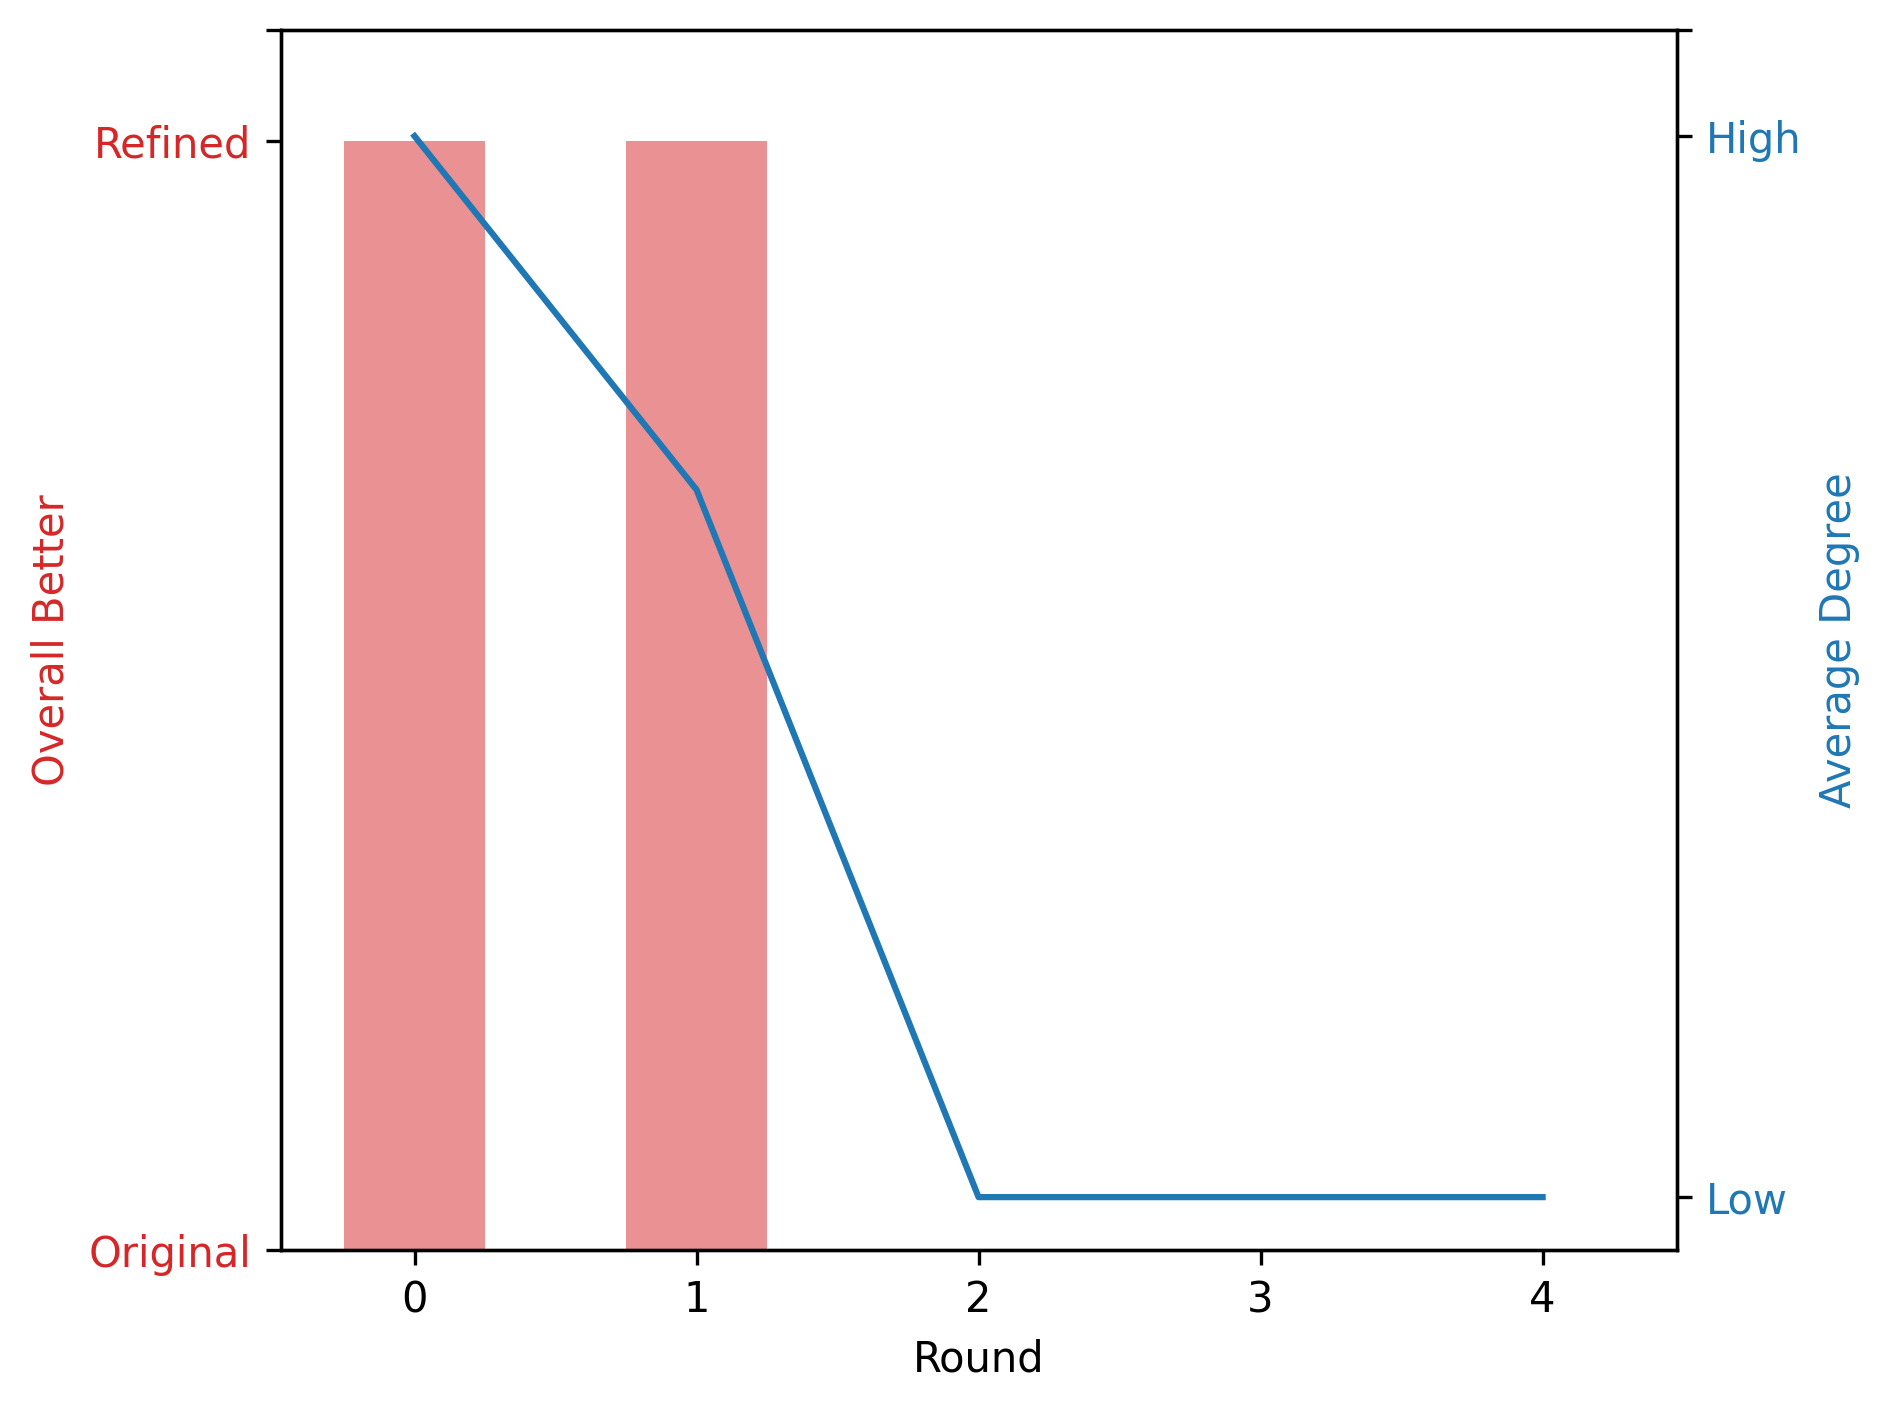

In [44]:
# plot overall_better_list and average_degree_list
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(dpi=300)

round_list = list(range(len(overall_better_list)))

color = 'tab:red'
ax1.set_xlabel('Round')
ax1.set_ylabel('Overall Better', color=color)
ax1.bar(round_list, color=color, height=overall_better_list, alpha=0.5, width=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1.0, 1.1])
ax1.set_yticklabels(['Original', 'Refined', ''])


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Degree', color=color)
ax2.plot(round_list, average_degree_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1.0, 1.1])
ax2.set_yticklabels(['Low', 'High', ''])

fig.tight_layout()
plt.show()

### Final Output

In [45]:
final_situational_detail_generation_system_prompt = original_prompt
sdg_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', final_situational_detail_generation_system_prompt),
        ('human', situational_detail_generation_task_prompt),
    ]
)
sdg_model = sdg_prompt | llm
situational_details_output = sdg_model.invoke(sdg_input_dict)
situational_details = situational_details_output.content
save_json(f'results/situational_details_{run_id_str}.json', json.loads(situational_details))

In [46]:
original_sdg_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', situational_detail_generation_original_system_prompt),
        ('human', situational_detail_generation_task_prompt),
    ]
)
original_sdg_model = original_sdg_prompt | llm
original_situational_details_output = original_sdg_model.invoke(sdg_input_dict)
original_situational_details = original_situational_details_output.content
save_json(f'results/original_situational_details_{run_id_str}.json', json.loads(original_situational_details))
print(original_situational_details)

{
"scenario": {
    "id": "2",
    "title": "项目截止日期临近",
    "background": "项目的截止日期临近，你感觉自己有些跟不上进度。你的团队领导在每日站会上询问每个人的进展。",
    "user_role": "Junior Programmer",
    "relation_type": "上级关系"
},
"num_situations": 5,
"situations": [{
    "id": "1",
    "description": "领导询问你的进展",
    "options": ["坦诚说进度慢", "说一切顺利", "避重就轻", "求助同事"],
    "eq_dimension": "情绪掌控力"
},
{
    "id": "2",
    "description": "领导表示关切",
    "options": ["表达感谢", "保持沉默", "简短回应", "转移话题"],
    "eq_dimension": "沟通表达力"
},
{
    "id": "3",
    "description": "同事私下询问",
    "options": ["分享困难", "保持神秘", "转移话题", "询问对方"],
    "eq_dimension": "人际平衡术"
},
{
    "id": "4",
    "description": "工作任务激增",
    "options": ["请求帮助", "默默承受", "抱怨工作", "寻求指导"],
    "eq_dimension": "情绪侦查/阅读力"
},
{
    "id": "5",
    "description": "领导要求加班",
    "options": ["同意加班", "拒绝加班", "提出疑问", "协商时间"],
    "eq_dimension": "社交得体度"
}]
}


In [47]:
sdg_comparison_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', sdg_comparison_system_prompt),
        ('human', sdg_comparison_task_prompt),
    ]
)
sdg_comparison_model = sdg_comparison_prompt | llm
input_dict_for_comparison = {
    'sdg_critic_system_prompt': sdg_critic_system_prompt,
    'situations_a': original_situational_details,
    'situations_b': situational_details,
}
comparison_analysis = sdg_comparison_model.invoke(input_dict_for_comparison)
comparison_analysis = comparison_analysis.content
try:
    comparison_analysis_dict = json.loads(comparison_analysis)
except:
    print(comparison_analysis)

comparison_analysis_dict

{'better': 1,
 'degree': 0.5,
 'overall': '总体而言，连续职场情景B在多个维度上的表现略优于情景A，尤其是在情境的复杂性和动态性方面。尽管两者在真实性和语言简洁性方面表现相当，但情景B在选项的多样性和对情商维度的覆盖上更为全面。',
 'comments': {'realism': '两个情景都非常贴近实际职场环境，并且描述了程序员在项目截止日期临近时可能遇到的典型问题。情景A和B在这一点上表现相当。',
  'diversity': '情景B在选项的多样性方面表现得更好。例如，情景B中提供了更多元化的选项，如回避问题、寻找借口、主动寻求帮助等，能够更全面地反映出不同的情感反应。相比之下，情景A的选项相对单一。',
  'dimension_coverage': '情景B在情商维度的覆盖上更为全面，能够更充分地考察不同情商维度。例如，情景B在沟通表达力和人际平衡术等维度上的选项更具代表性和现实意义，而情景A在这些方面稍显不足。',
  'dynamics': '情景B的选项更能够影响情境的后续发展，推动场景自然演变。例如，情景B中的“领导对你进度表担忧”情境提供了多种回应方式，这些方式会直接影响后续的进展。情景A则相对静态，选项较少影响后续情境。',
  'complexity': '情景B的复杂性更高，能够更好地挑战用户的情商。情景B中的情况设计较为复杂，涵盖了多步骤情境和变化条件，而情景A则相对简单，缺乏足够的深度。',
  'language': '两个情景在语言的简洁性和清晰度方面表现相当。都能够在有限的字数内传达出明确的信息，语言表述清晰明了。'}}

## Statistical Analysis

In [66]:
file_type = ['slc_refinement_results', 'sdg_refinement_results']

slc_refinement_results_list = []
sdg_refinement_results_list = []
for ftype in file_type:
    for i in range(10):
        if ftype == 'slc_refinement_results':
            run_id_str = '20240906-034617'
        elif ftype == 'sdg_refinement_results':
            run_id_str = '20240905-190519'
        file_path = f'results/{ftype}_{i}_{run_id_str}.json'
        if not os.path.exists(file_path):
            break
        refinement_results = load_json(file_path)
        print(f'{ftype} {i}: {refinement_results["overall_better"]} ({refinement_results["average_degree"]})')
        if ftype == 'slc_refinement_results':
            slc_refinement_results_list.append(refinement_results)
        elif ftype == 'sdg_refinement_results':
            sdg_refinement_results_list.append(refinement_results)

slc_refinement_results 0: 1 (0.8333333333333334)
slc_refinement_results 1: 0 (0.5)
slc_refinement_results 2: 1 (0.5)
slc_refinement_results 3: 0 (0.5)
slc_refinement_results 4: 1 (0.7333333333333334)
slc_refinement_results 5: 0 (0.5)
slc_refinement_results 6: 0 (0.6666666666666666)
slc_refinement_results 7: 0 (0.5)
sdg_refinement_results 0: 1 (1.0)
sdg_refinement_results 1: 1 (0.6666666666666666)
sdg_refinement_results 2: 0 (0.0)
sdg_refinement_results 3: 0 (0.0)
sdg_refinement_results 4: 0 (0.0)


In [76]:
slc_refined_critic_comments_score_list = [refinement_results['refined_critic_comments']['score'] for refinement_results in slc_refinement_results_list]
sdg_refined_critic_comments_score_list = [refinement_results['refined_critic_comments']['score'] for refinement_results in sdg_refinement_results_list]

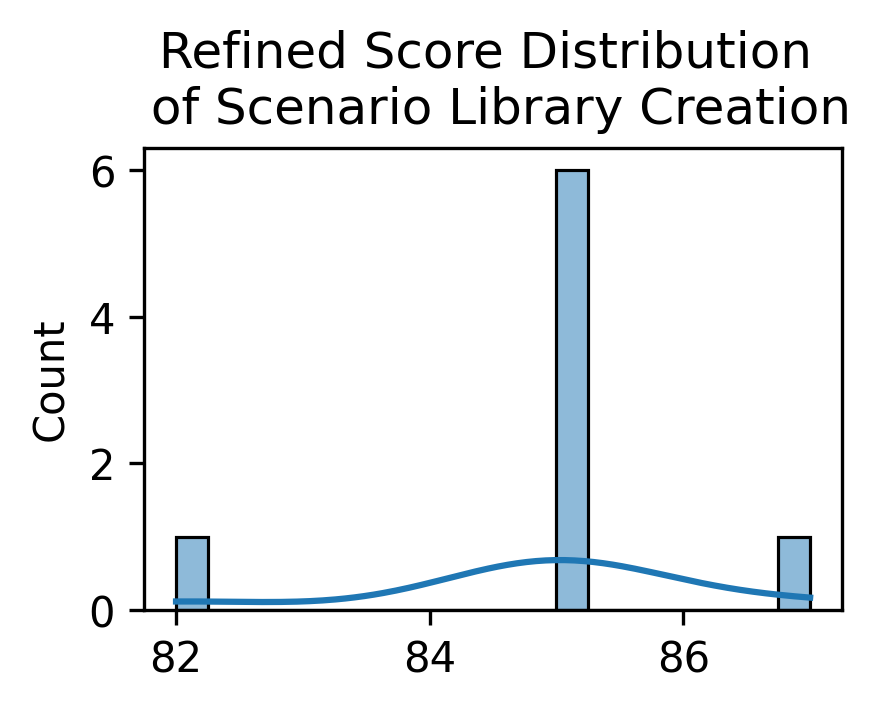

In [75]:
# plot score distribution
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=300, figsize=(3, 2))
sns.histplot(slc_refined_critic_comments_score_list, bins=20, kde=True, ax=ax)
plt.title('Refined Score Distribution \n of Scenario Library Creation')
plt.show()

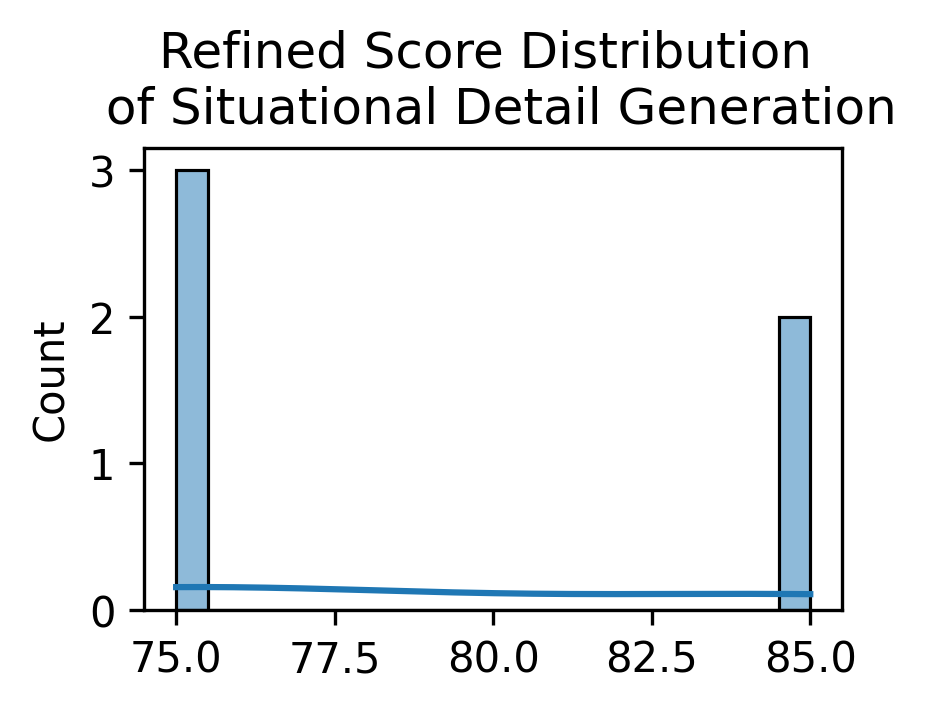

In [77]:
fig, ax = plt.subplots(dpi=300, figsize=(3, 2))

sns.histplot(sdg_refined_critic_comments_score_list, bins=20, kde=True, ax=ax)
plt.title('Refined Score Distribution \n of Situational Detail Generation')
plt.show()